<a href="https://colab.research.google.com/github/Ad450/AI_models/blob/main/MSc_research_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# Install required libraries
!pip install -q transformers torch accelerate bitsandbytes scipy matplotlib seaborn

In [28]:
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

def load_quantized_pair(model_name, is_decoder=False):
    """
    Loads a pair of models: one in FP32 and one in INT8 for comparison.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Load original FP32 Model
    model_fp32 = AutoModel.from_pretrained(model_name, output_attentions=True)

    # Configure 8-bit quantization
    quant_config = BitsAndBytesConfig(load_in_8bit=True)

    try:
        # Using AutoModel to correctly handle the load_in_8bit dispatch
        model_int8 = AutoModel.from_pretrained(
            model_name,
            quantization_config=quant_config,
            device_map="auto",
            output_attentions=True
        )
        print(f"Successfully loaded {model_name} in FP32 and INT8.")
    except Exception as e:
        print(f"INT8 loading failed: {e}. Ensure you are using a GPU runtime.")
        model_int8 = None

    return tokenizer, model_fp32, model_int8

# Initialize DistilBERT and GPT-2 as specified in your research plan
distil_tok, distil_fp32, distil_int8 = load_quantized_pair("distilbert-base-uncased")
gpt2_tok, gpt2_fp32, gpt2_int8 = load_quantized_pair("gpt2", is_decoder=True)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Successfully loaded distilbert-base-uncased in FP32 and INT8.


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2Model LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2Model LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Successfully loaded gpt2 in FP32 and INT8.


In [29]:
from scipy.spatial.distance import cosine

def extract_attention(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Returns a tuple of tensors (one per layer)
    return outputs.attentions

def compare_attention_stability(attn_fp32, attn_int8):
    """
    Calculates stability using Cosine Similarity as per the research objectives.
    """
    layer_similarities = []

    for i in range(len(attn_fp32)):
        # Flatten the tensors for comparison
        vec_fp32 = attn_fp32[i].cpu().numpy().flatten()
        vec_int8 = attn_int8[i].cpu().numpy().flatten()

        # Calculate Cosine Similarity (1 - cosine distance)
        similarity = 1 - cosine(vec_fp32, vec_int8)
        layer_similarities.append(similarity)

    return layer_similarities

# Test with your sample sentence
sample_text = "The quick brown fox jumps over the lazy dog near the river bank."
attn_f = extract_attention(distil_fp32, distil_tok, sample_text)
attn_i = extract_attention(distil_int8, distil_tok, sample_text)

stability_results = compare_attention_stability(attn_f, attn_i)
print(f"Layer-wise Stability Scores of DistilBert: {stability_results}")

/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Layer-wise Stability Scores of DistilBert: [np.float32(0.9999627), np.float32(0.9998426), np.float32(0.9998055), np.float32(0.9998132), np.float32(0.999786), np.float32(0.9992447)]


In [30]:
import numpy as np
from scipy.stats import spearmanr
from scipy.spatial.distance import jensenshannon

def calculate_top_k_overlap(attn_fp32, attn_int8, k=5):
    """
    Measures the percentage of the same top-K tokens being attended to.
    """
    # Get indices of top K values
    idx_fp32 = np.argsort(attn_fp32)[-k:]
    idx_int8 = np.argsort(attn_int8)[-k:]

    # Calculate intersection
    overlap = len(np.intersect1d(idx_fp32, idx_int8))
    return overlap / k

def compute_all_metrics(map_fp32, map_int8):
    """
    Computes JS Divergence and Spearman Rank for a layer.
    """
    # Flatten across heads for a layer-wise snapshot
    m1 = map_fp32.detach().cpu().numpy().flatten()
    m2 = map_int8.detach().cpu().numpy().flatten()

    # Jensen-Shannon Divergence (lower is more stable)
    js_div = jensenshannon(m1, m2)

    # Spearman Rank Correlation (closer to 1 is more stable)
    corr, _ = spearmanr(m1, m2)

    # Top-5 Overlap
    tk_overlap = calculate_top_k_overlap(m1, m2, k=5)

    return {"js_divergence": js_div, "spearman_rank": corr, "top_5_overlap": tk_overlap}

In [31]:
def run_comparative_study(model_f, model_i, tok, sentence, model_label):
    print(f"--- Analyzing {model_label} ---")
    attn_f = extract_attention(model_f, tok, sentence)
    attn_i = extract_attention(model_i, tok, sentence)

    results = []
    for layer_idx in range(len(attn_f)):
        metrics = compute_all_metrics(attn_f[layer_idx], attn_i[layer_idx])
        metrics['layer'] = layer_idx
        metrics['model'] = model_label
        results.append(metrics)
    return results

# Process both models as per the research plan [cite: 8]
distil_results = run_comparative_study(distil_fp32, distil_int8, distil_tok, sample_text, "DistilBERT")
gpt2_results = run_comparative_study(gpt2_fp32, gpt2_int8, gpt2_tok, sample_text, "GPT-2")

--- Analyzing DistilBERT ---
--- Analyzing GPT-2 ---


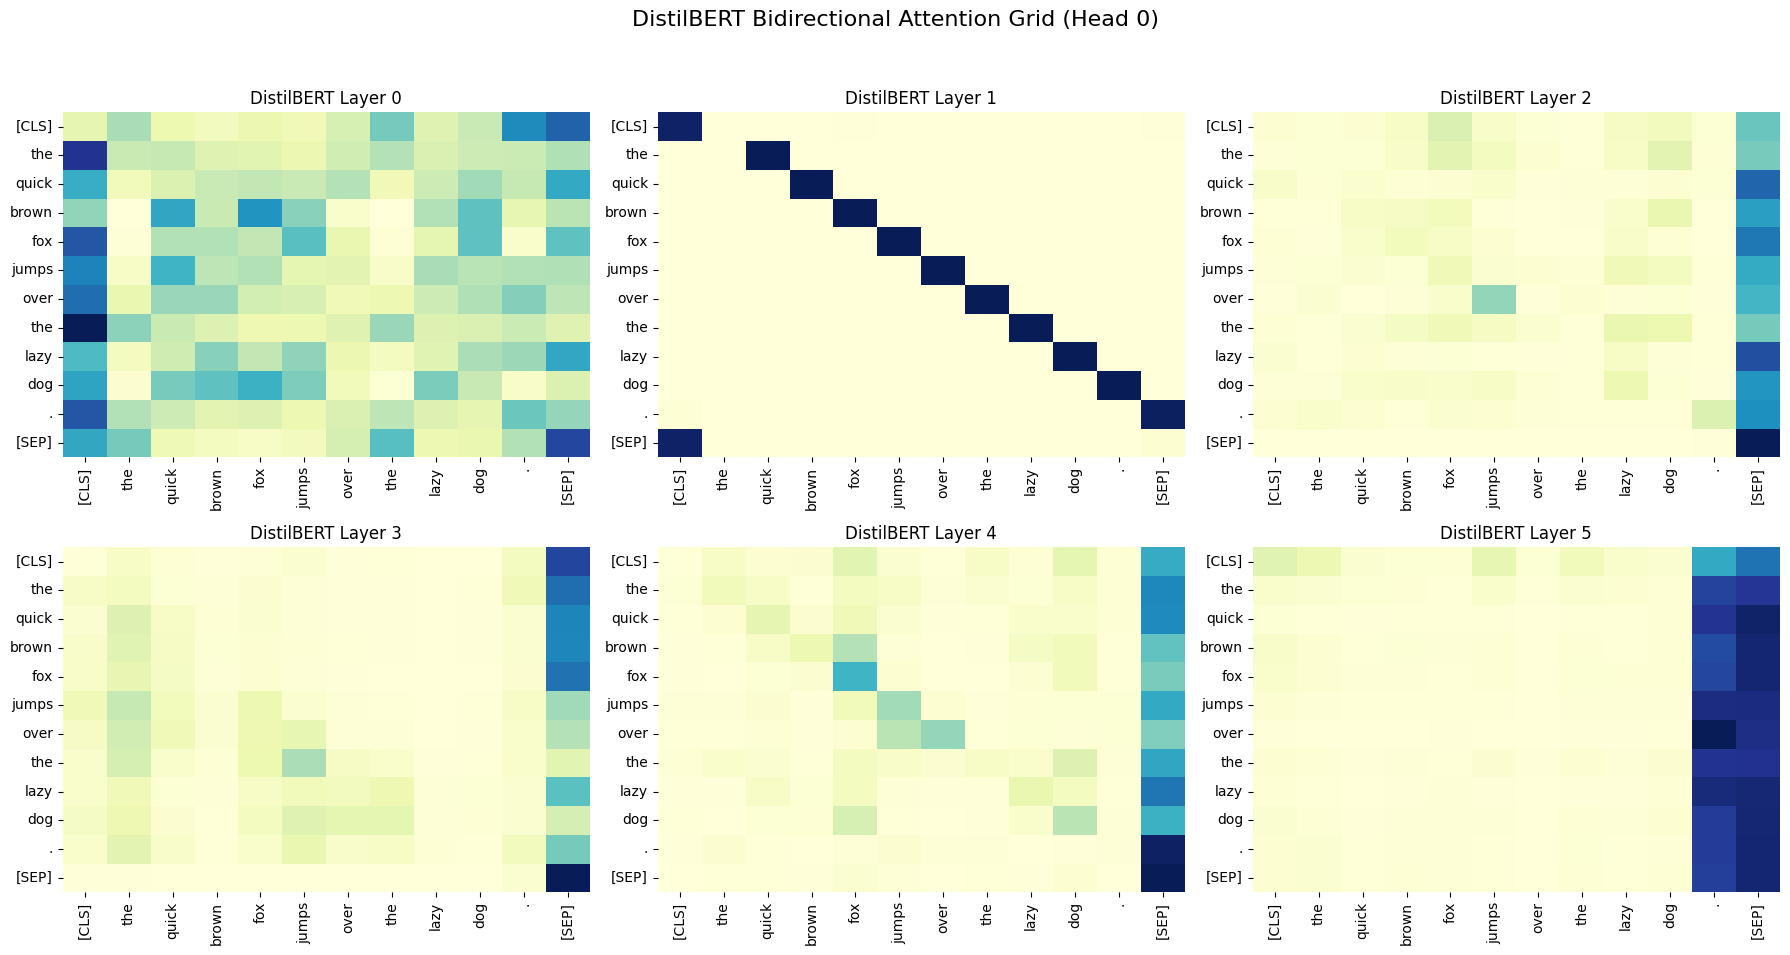

In [32]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_distilbert_all_layers(model, tokenizer, sentence, head=0):
    """
    Plots the attention weights for all 6 layers of DistilBERT.
    Bidirectional attention allows words to look both forward and backward.
    """
    # 1. Prepare inputs
    inputs = tokenizer(sentence, return_tensors="pt")
    # Extract tokens for labeling the axes
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # 2. Get all attention weights from the model
    with torch.no_grad():
        outputs = model(**inputs)
        # DistilBERT has 6 layers of attention
        all_attentions = outputs.attentions

    # 3. Setup the 2x3 Grid Plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i in range(len(all_attentions)):
        # Extract attention for current layer, first head
        # Shape is [batch, head, seq, seq] -> we take [0, head]
        attn_matrix = all_attentions[i][0, head].cpu().numpy()

        sns.heatmap(attn_matrix,
                    ax=axes[i],
                    xticklabels=tokens,
                    yticklabels=tokens,
                    cmap="YlGnBu",
                    annot=False, # Set to True if you want to see the numbers
                    cbar=False)

        axes[i].set_title(f"DistilBERT Layer {i}")

    plt.suptitle(f"DistilBERT Bidirectional Attention Grid (Head {head})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the visualization for DistilBERT
# Ensure your model was loaded with 'output_attentions=True'
plot_distilbert_all_layers(distil_fp32, distil_tok, "The quick brown fox jumps over the lazy dog.")

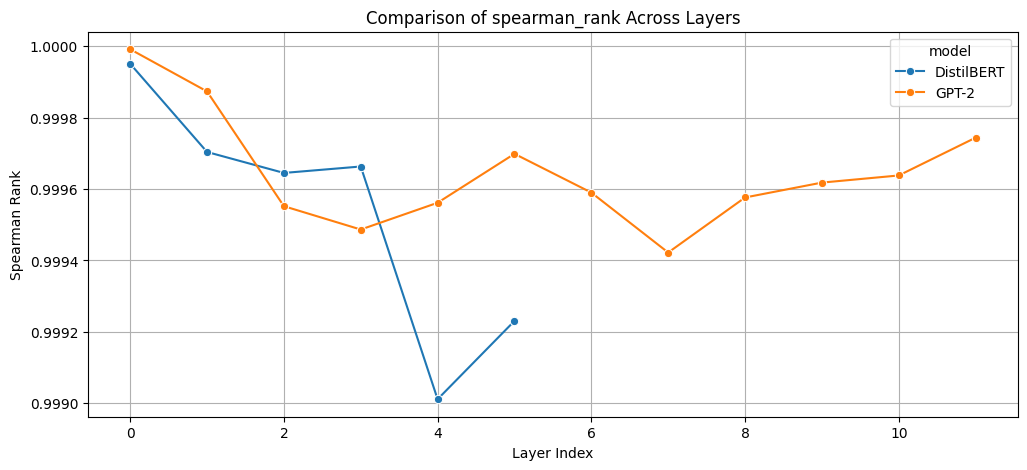

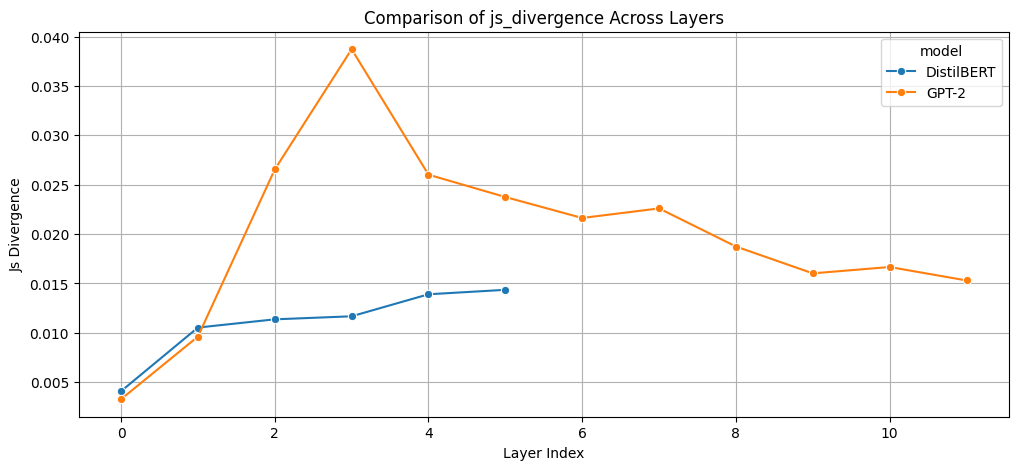

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine results into a DataFrame
df = pd.DataFrame(distil_results + gpt2_results)

def plot_research_results(df, metric_name):
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x='layer', y=metric_name, hue='model', marker='o')
    plt.title(f"Comparison of {metric_name} Across Layers")
    plt.ylabel(metric_name.replace("_", " ").title())
    plt.xlabel("Layer Index")
    plt.grid(True)
    plt.show()

# Visualize the critical metrics defined in your proposal
plot_research_results(df, 'spearman_rank')
plot_research_results(df, 'js_divergence')

In [34]:
import pandas as pd
import torch

def calculate_simple_difference(attn_fp32, attn_int8):
    """
    Calculates the direct numerical change between FP32 and INT8.
    This fulfills the objective of 'measuring the impact of quantization'.
    """
    difference_results = []

    for i in range(len(attn_fp32)):
        # 1. Get the numbers for this layer
        # [batch, heads, seq_len, seq_len]
        f32_vals = attn_fp32[i].detach().cpu().float()
        i8_vals = attn_int8[i].detach().cpu().float()

        # 2. Subtract them to find the 'Error' or 'Difference'
        # Using absolute values because we want to know the magnitude of change
        diff_matrix = torch.abs(f32_vals - i8_vals)

        # 3. Calculate the Average Difference for the whole layer
        avg_diff = diff_matrix.mean().item()

        # 4. Find the Maximum Difference (the biggest shift in focus)
        max_diff = diff_matrix.max().item()

        difference_results.append({
            "Layer": i,
            "Average Difference": avg_diff,
            "Biggest Single Shift": max_diff
        })

    return pd.DataFrame(difference_results)

# Run the calculation
distil_diff_df = calculate_simple_difference(attn_f, attn_i)

print("Quantization Impact: Numerical Difference per Layer")
print(distil_diff_df)

Quantization Impact: Numerical Difference per Layer
   Layer  Average Difference  Biggest Single Shift
0      0            0.000508              0.017249
1      1            0.001176              0.031696
2      2            0.001366              0.039761
3      3            0.001315              0.054451
4      4            0.001680              0.032166
5      5            0.002197              0.032040


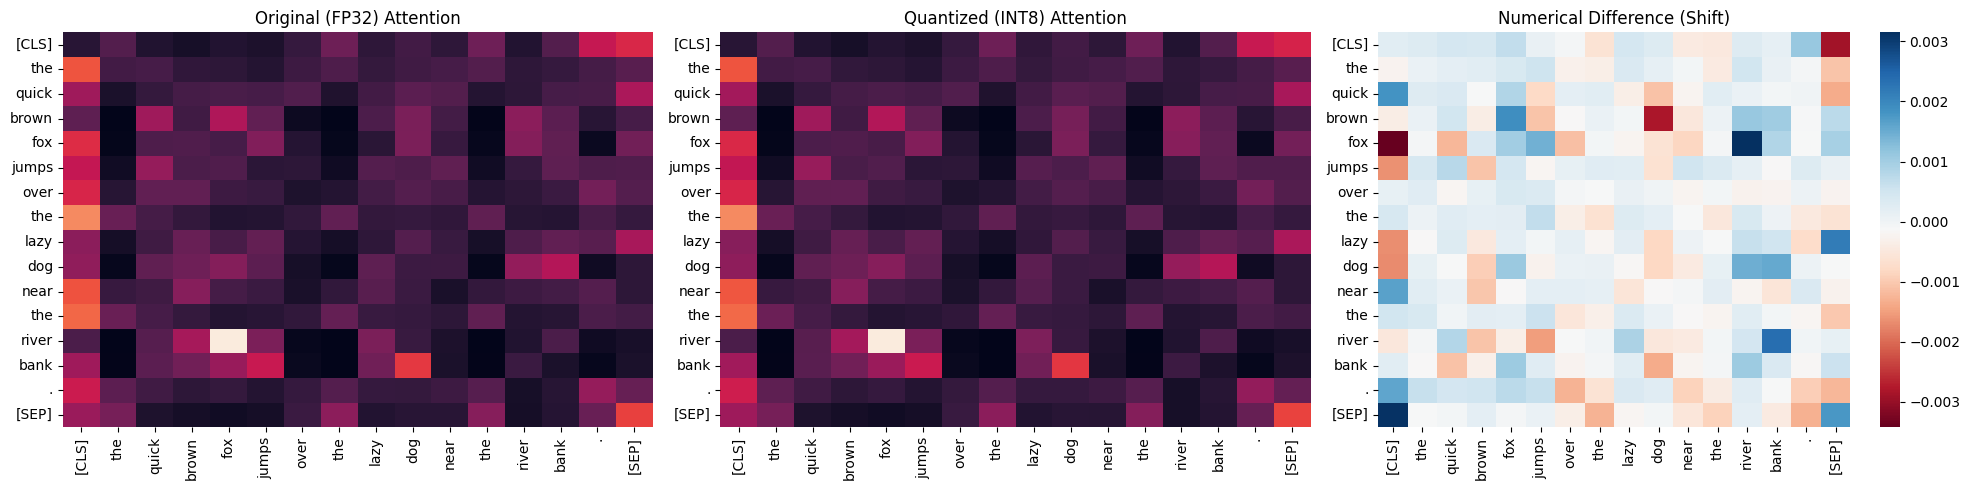

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comparison(attn_fp32, attn_int8, tokenizer, sentence, layer=0):
    tokens = tokenizer.tokenize(sentence)
    # Adding special tokens to labels
    labels = [tokenizer.cls_token] + tokens + [tokenizer.sep_token]

    # Extract data for the first head of the chosen layer
    f32 = attn_fp32[layer][0, 0].cpu().numpy()
    i8 = attn_int8[layer][0, 0].cpu().numpy()
    diff = i8 - f32 # This shows if attention increased or decreased

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Plot FP32
    sns.heatmap(f32, annot=False, xticklabels=labels, yticklabels=labels, ax=axes[0], cbar=False)
    axes[0].set_title("Original (FP32) Attention")

    # Plot INT8
    sns.heatmap(i8, annot=False, xticklabels=labels, yticklabels=labels, ax=axes[1], cbar=False)
    axes[1].set_title("Quantized (INT8) Attention")

    # Plot Difference
    sns.heatmap(diff, annot=False, xticklabels=labels, yticklabels=labels, ax=axes[2], cmap="RdBu")
    axes[2].set_title("Numerical Difference (Shift)")

    plt.tight_layout()
    plt.show()

# Visualize for the first layer
plot_comparison(attn_f, attn_i, distil_tok, sample_text, layer=0)

In [36]:
# metrics - GPT2
import numpy as np
from scipy.spatial.distance import cosine, jensenshannon
from scipy.stats import spearmanr

def calculate_advanced_metrics(attn_fp32, attn_int8, k=5):
    results = []

    for i in range(len(attn_fp32)):
        # Flattening [heads * seq * seq] to get a layer-wide stability score
        f32 = attn_fp32[i].detach().cpu().float().numpy().flatten()
        i8 = attn_int8[i].detach().cpu().float().numpy().flatten()

        # 1. Cosine Similarity (Alignment)
        cos_sim = 1 - cosine(f32, i8)

        # 2. JS Divergence (Distribution Shift)
        # Small epsilon to avoid log(0)
        js_div = jensenshannon(f32 + 1e-9, i8 + 1e-9)

        # 3. Spearman Rank (Importance Ordering)
        corr, _ = spearmanr(f32, i8)

        # 4. Top-K Overlap (Key Token Preservation)
        top_f32 = np.argsort(f32)[-k:]
        top_i8 = np.argsort(i8)[-k:]
        overlap = len(np.intersect1d(top_f32, top_i8)) / k

        results.append({
            "Layer": i,
            "Cosine_Similarity": cos_sim,
            "JS_Divergence": js_div,
            "Spearman_Rank": corr,
            "Top_5_Overlap": overlap
        })

    return pd.DataFrame(results)

In [37]:
#DistilBert Metrics

distil_metrics_df = calculate_advanced_metrics(attn_f, attn_i)

print("--- DistilBERT Advanced Stability Report ---")
print(distil_metrics_df.to_string(index=False))

--- DistilBERT Advanced Stability Report ---
 Layer  Cosine_Similarity  JS_Divergence  Spearman_Rank  Top_5_Overlap
     0           0.999963       0.004078       0.999951            1.0
     1           0.999843       0.010525       0.999704            1.0
     2           0.999806       0.011359       0.999645            1.0
     3           0.999813       0.011667       0.999663            1.0
     4           0.999786       0.013898       0.999012            0.8
     5           0.999245       0.014349       0.999231            0.8


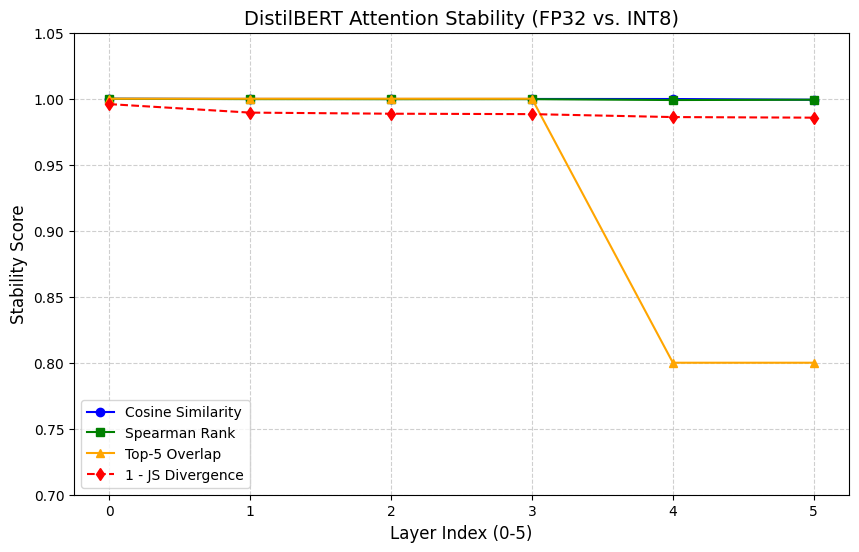

In [38]:
def plot_distilbert_metrics(df):
    plt.figure(figsize=(10, 6))

    # Standardizing metrics to 'Higher is Better'
    plt.plot(df['Layer'], df['Cosine_Similarity'], marker='o', label='Cosine Similarity', color='blue')
    plt.plot(df['Layer'], df['Spearman_Rank'], marker='s', label='Spearman Rank', color='green')
    plt.plot(df['Layer'], df['Top_5_Overlap'], marker='^', label='Top-5 Overlap', color='orange')
    plt.plot(df['Layer'], 1 - df['JS_Divergence'], marker='d', label='1 - JS Divergence', linestyle='--', color='red')

    plt.title("DistilBERT Attention Stability (FP32 vs. INT8)", fontsize=14)
    plt.xlabel("Layer Index (0-5)", fontsize=12)
    plt.ylabel("Stability Score", fontsize=12)
    plt.xticks(range(6))
    plt.ylim(0.7, 1.05) # DistilBERT is often quite stable, so we zoom in
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

plot_distilbert_metrics(distil_metrics_df)

In [39]:
# GPT 2 Metrics

gpt2_attn_f = extract_attention(gpt2_fp32, gpt2_tok, sample_text)
gpt2_attn_i = extract_attention(gpt2_int8, gpt2_tok, sample_text)

gpt2_diff_df = calculate_simple_difference(gpt2_attn_f, gpt2_attn_i)

print("GPT-2 Quantization Impact: Numerical Difference per Layer")
print(gpt2_diff_df)

GPT-2 Quantization Impact: Numerical Difference per Layer
    Layer  Average Difference  Biggest Single Shift
0       0            0.000386              0.014548
1       1            0.001264              0.027622
2       2            0.003381              0.092457
3       3            0.004838              0.138695
4       4            0.003084              0.097736
5       5            0.002658              0.114553
6       6            0.002430              0.104603
7       7            0.002237              0.084793
8       8            0.002062              0.058383
9       9            0.001480              0.067322
10     10            0.001757              0.086384
11     11            0.001883              0.050534


/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


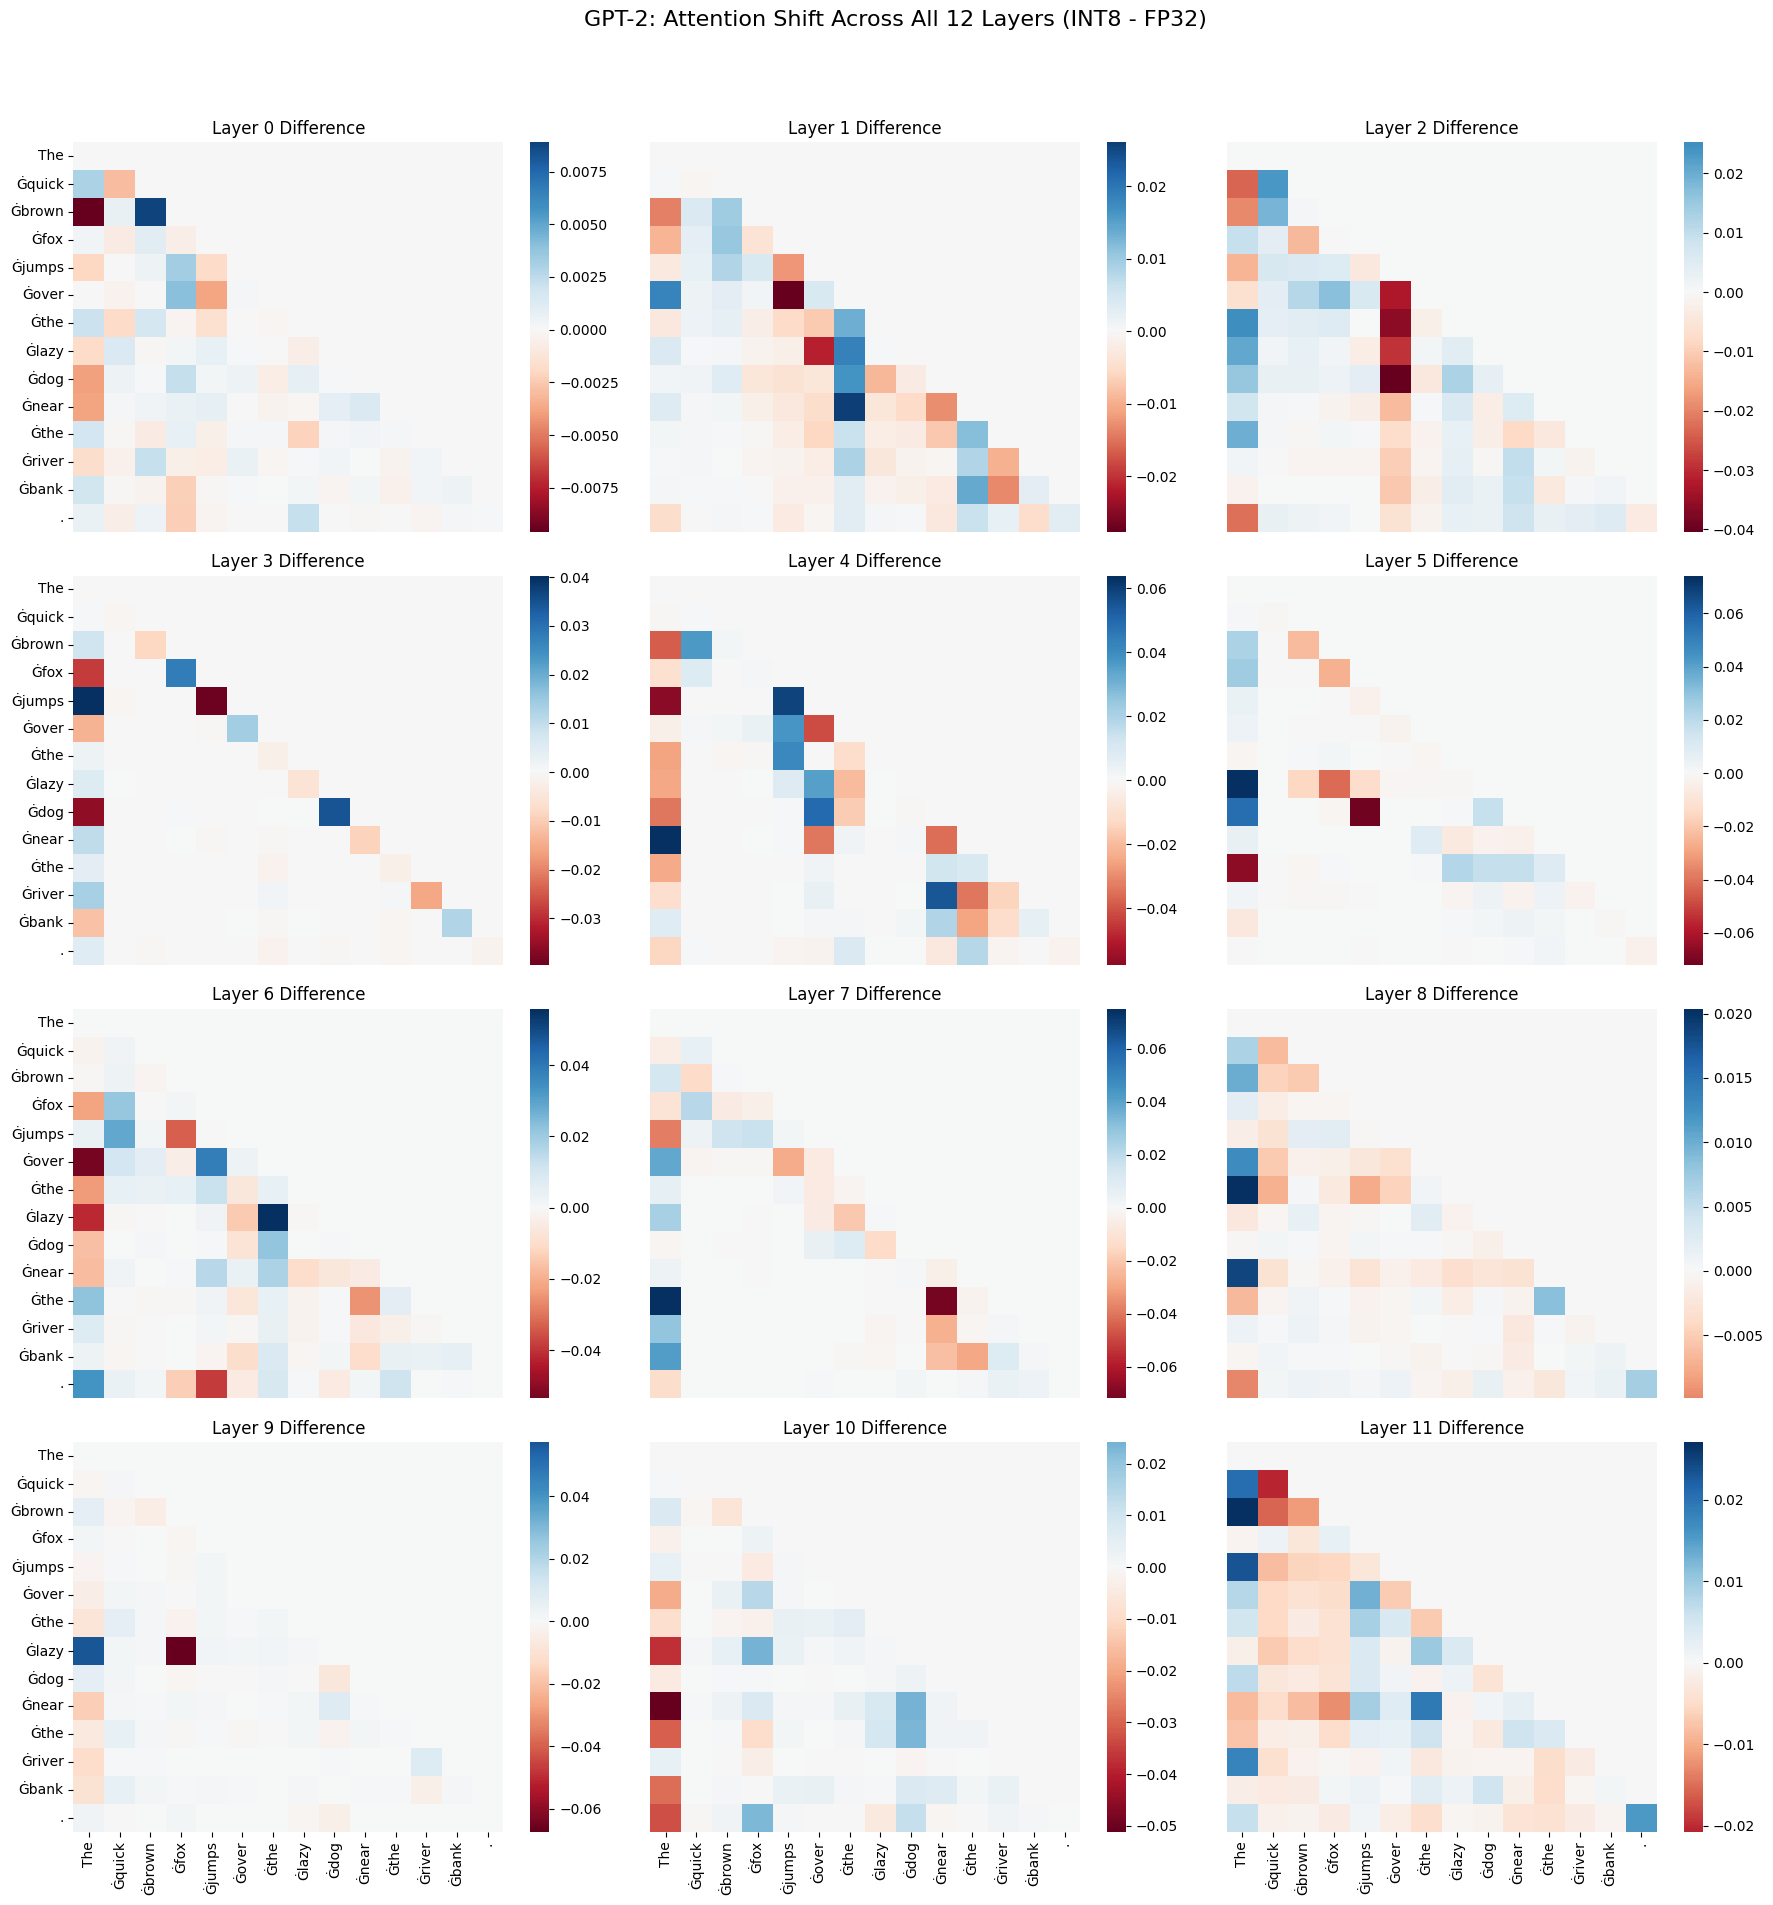

In [40]:
# visualising GPT2 layers

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_all_gpt2_layers(attn_fp32, attn_int8, tokenizer, sentence):
    # Prepare token labels for the axes
    tokens = tokenizer.tokenize(sentence)
    # GPT2 tokenizer doesn't use [CLS], it uses <|endoftext|> or just raw tokens
    labels = tokens

    num_layers = len(attn_fp32)
    cols = 3
    rows = (num_layers // cols) + (1 if num_layers % cols != 0 else 0)

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    axes = axes.flatten()

    for i in range(num_layers):
        # Extract first head for each layer
        f32 = attn_fp32[i][0, 0].detach().cpu().float().numpy()
        i8 = attn_int8[i][0, 0].detach().cpu().float().numpy()

        # Calculate the difference (Shift)
        diff = i8 - f32

        # Plot on the grid
        sns.heatmap(diff, ax=axes[i], cmap="RdBu", center=0, cbar=True,
                    xticklabels=labels if i >= (num_layers - cols) else False,
                    yticklabels=labels if i % cols == 0 else False)

        axes[i].set_title(f"Layer {i} Difference")

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("GPT-2: Attention Shift Across All 12 Layers (INT8 - FP32)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the visualization
visualize_all_gpt2_layers(gpt2_attn_f, gpt2_attn_i, gpt2_tok, sample_text)

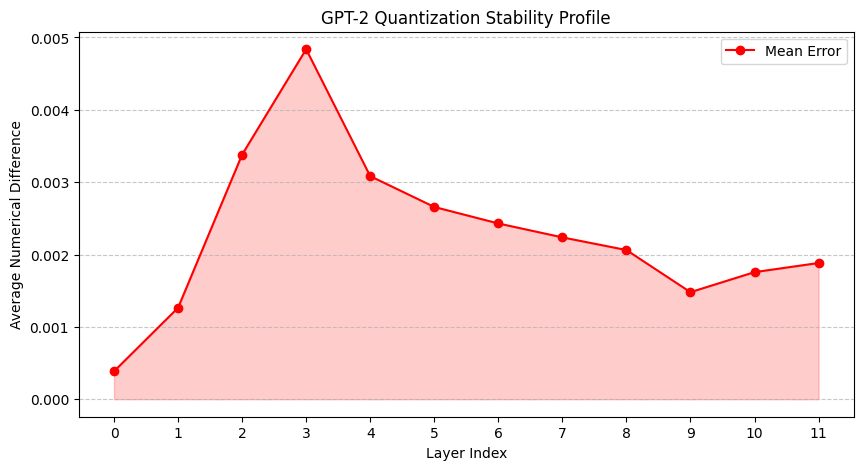

In [41]:
def plot_global_drift(df, model_name="GPT-2"):
    plt.figure(figsize=(10, 5))
    plt.plot(df['Layer'], df['Average Difference'], marker='o', linestyle='-', color='red', label='Mean Error')
    plt.fill_between(df['Layer'], 0, df['Average Difference'], alpha=0.2, color='red')

    plt.title(f"{model_name} Quantization Stability Profile")
    plt.xlabel("Layer Index")
    plt.ylabel("Average Numerical Difference")
    plt.xticks(range(12))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

plot_global_drift(gpt2_diff_df)

In [42]:


# Apply to GPT-2
gpt2_metrics_df = calculate_advanced_metrics(gpt2_attn_f, gpt2_attn_i)
print("GPT-2 Advanced Stability Report")
print(gpt2_metrics_df.to_string(index=False))


GPT-2 Advanced Stability Report
 Layer  Cosine_Similarity  JS_Divergence  Spearman_Rank  Top_5_Overlap
     0           0.999982       0.003265       0.999992            0.4
     1           0.999854       0.009612       0.999873            0.6
     2           0.998812       0.026540       0.999552            0.6
     3           0.997408       0.038725       0.999487            0.8
     4           0.999068       0.026016       0.999562            0.6
     5           0.999193       0.023751       0.999699            0.4
     6           0.999461       0.021626       0.999590            0.8
     7           0.999505       0.022597       0.999422            0.8
     8           0.999616       0.018737       0.999576            0.6
     9           0.999773       0.016016       0.999618            0.4
    10           0.999707       0.016661       0.999638            0.4
    11           0.999756       0.015297       0.999744            0.0


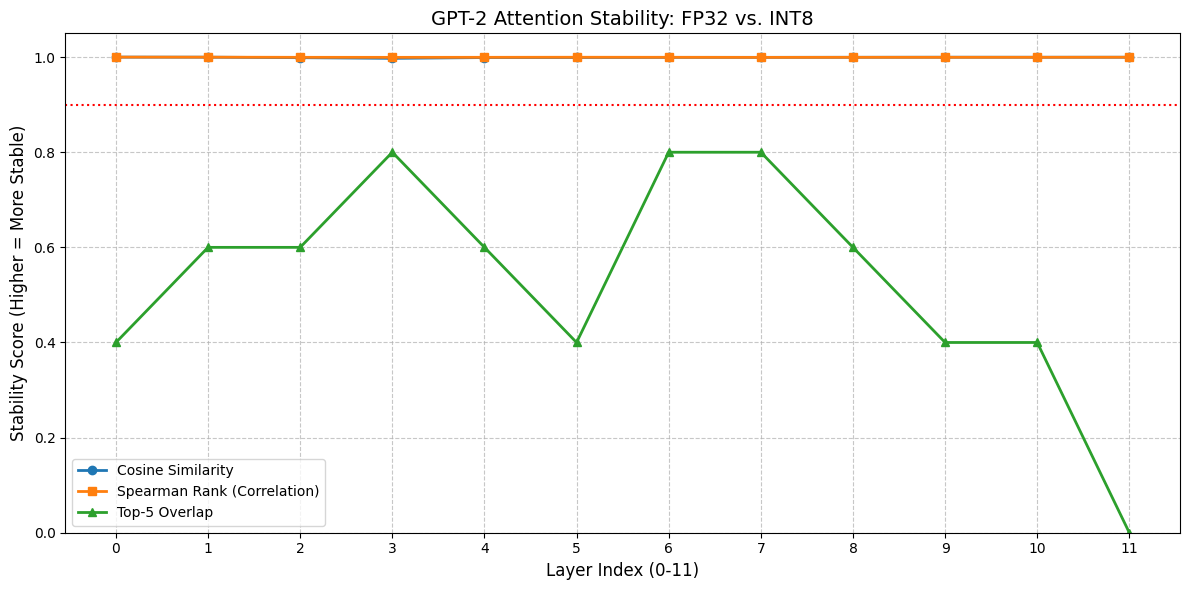

In [43]:
import matplotlib.pyplot as plt

def plot_gpt2_stability_metrics(df):
    """
    Plots Cosine Similarity and other metrics on a single graph.
    Objective: Identify which layers are most sensitive to INT8 quantization.
    """
    plt.figure(figsize=(12, 6))

    # We plot everything that is on a 0-1 scale together
    plt.plot(df['Layer'], df['Cosine_Similarity'], marker='o', label='Cosine Similarity', linewidth=2)
    plt.plot(df['Layer'], df['Spearman_Rank'], marker='s', label='Spearman Rank (Correlation)', linewidth=2)
    plt.plot(df['Layer'], df['Top_5_Overlap'], marker='^', label='Top-5 Overlap', linewidth=2)

    # Jensen-Shannon is a 'distance' (lower is better), so we often plot it separately
    # or invert it to keep the 'Higher is Better' theme.
    # For now, let's keep the core stability metrics.

    plt.title("GPT-2 Attention Stability: FP32 vs. INT8", fontsize=14)
    plt.xlabel("Layer Index (0-11)", fontsize=12)
    plt.ylabel("Stability Score (Higher = More Stable)", fontsize=12)
    plt.xticks(range(12))
    plt.ylim(0, 1.05) # Metrics are between 0 and 1
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower left')

    # Adding a horizontal line at 0.90 to show a 'Trust' threshold
    plt.axhline(y=0.90, color='red', linestyle=':', label='90% Stability Threshold')

    plt.tight_layout()
    plt.show()

# Assuming gpt2_metrics_df was generated by the calculate_advanced_metrics function
plot_gpt2_stability_metrics(gpt2_metrics_df)

In [44]:
!pip install bertviz